In [1]:
%%writefile modelsaver.py
import importlib
import numpy as np
import os
import sys
import random
import pickle
import tensorflow as tf
import metrics.writer as metrics_writer

from baseline_constants import MAIN_PARAMS, MODEL_PARAMS
from client import Client
from server import Server
from model import ServerModel
from utils.constants import DATASETS


STAT_METRICS_PATH = 'metrics/stat_metrics.csv'
SYS_METRICS_PATH = 'metrics/sys_metrics.csv'

def online(clients):
    """We assume all users are always online."""
    return clients

def save_model(server_model, dataset, model):
    """Saves the given server model on checkpoints/dataset/model.ckpt."""
    # Save server model
    ckpt_path = os.path.join('checkpoints', dataset)
    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)
    save_path = server_model.save(os.path.join(ckpt_path, '%s.ckpt' % model))
    print('Model saved in path: %s' % save_path)


def print_metrics(metrics, weights):
    ordered_weights = [weights[c] for c in sorted(weights)]
    metric_names = metrics_writer.get_metrics_names(metrics)
    for metric in metric_names:
        ordered_metric = [metrics[c][metric] for c in sorted(metrics)]
        print('%s: %g, 10th percentile: %g, 90th percentile %g' \
              % (metric,
                 np.average(ordered_metric, weights=ordered_weights),
                 np.percentile(ordered_metric, 10),
                 np.percentile(ordered_metric, 90)))

class Model_Saver:
    
    def __init__(self, users, groups, train_data, test_data):
        self.users = users
        self.train_data = train_data
        self.test_data = test_data
        
    def model_config(self, config, dataset, my_model):   
        shared_model = my_model
        model_path = '%s/%s.py' % (dataset, shared_model)
        if not os.path.exists(model_path):
            print('Please specify a valid dataset and a valid model.')
        model_path = '%s.%s' % (dataset, shared_model)

        print('############################## %s ##############################' % model_path)
        mod = importlib.import_module(model_path)
        ClientModel = getattr(mod, 'ClientModel')  
        # Suppress tf warnings
        tf.logging.set_verbosity(tf.logging.WARN)

        # Create 2 models
        model_params = MODEL_PARAMS[model_path]
        model_params_list = list(model_params)
        model_params_list.insert(0, config["seed"])
        model_params_list[1] = config["lr"] 
        model_params = tuple(model_params_list)
        tf.reset_default_graph()
        client_model = ClientModel(*model_params)

        # Create server
        server = Server(client_model)

        # Create clients
        _users = self.users
        groups = [[] for _ in _users]
        clients =  [Client(u, g, self.train_data[u], self.test_data[u], client_model) \
                    for u, g in zip(_users, groups)]
        print('%d Clients in Total' % len(clients)) 
        return clients, server, client_model
    
    def save_clients(self, server, num_rounds, dataset):
        batched = []
        update = server.updates[0]
        if (dataset == "femnist"):
            dense_pos = 4
        else:
            dense_pos = len(update[1]) -2
        w_dense_shape = np.array(update[1][dense_pos]).shape
        print(w_dense_shape)
        for client, update in zip(server.selected_clients, server.updates):
            name = client.id
            w_dense = np.array(update[1][dense_pos])
            tup = (name, w_dense)
            batched.append(tup)
        
        saver_path = os.path.join('saver', dataset)
        if not os.path.exists(saver_path):
            os.makedirs(saver_path)
        with open(os.path.join(saver_path, "clients_dense_r{}.pb".format(num_rounds)), "wb+") as f:
            pickle.dump(batched, f)
        print("--- clients parameter saved. ---")
    
    def begins(self, config, args):
        clients, server, client_model = self.model_config(config, args.dataset, 'cnn')  
    
        num_rounds = config["num-rounds"]
        eval_every = config["eval-every"]
        epochs_per_round = config['epochs']
        batch_size = config['batch-size']
        clients_per_round = config["clients-per-round"]
        
        # Test untrained model on all clients
        stat_metrics = server.test_model(clients)
        all_ids, all_groups, all_num_samples = server.get_clients_info(clients)
#         metrics_writer.print_metrics(0, all_ids, stat_metrics, all_groups, all_num_samples, STAT_METRICS_PATH)
        print_metrics(stat_metrics, all_num_samples)

        # Simulate training
        for i in range(num_rounds):
            print('--- Round %d of %d: Training %d Clients ---' % (i+1, num_rounds, clients_per_round))

            server.select_clients(online(clients), num_clients=clients_per_round)
            c_ids, c_groups, c_num_samples = server.get_clients_info(None)

            sys_metics = server.train_model(single_center=None, num_epochs=epochs_per_round, batch_size=batch_size, minibatch=None)            
            server.update_model_wmode()

            # Test model on all clients
            if (i + 1) % eval_every == 0 or (i + 1) == num_rounds:
                stat_metrics = server.test_model(clients)
                print_metrics(stat_metrics, all_num_samples)

        # Save server model
        save_path = os.path.join("checkpoints", args.dataset)
        server.save_model(save_path)

        # Close models
    #     server_model.close()
        sys_metics = server.train_model(single_center=None, num_epochs=epochs_per_round, batch_size=batch_size, minibatch=None)
        self.save_clients(server, num_rounds, args.dataset)
        client_model.close()
        return 0
    
    def ends(self):
        print("experiment of Modelsaver finished.")
        return

Overwriting modelsaver.py


[[-0.00050113 -0.09771717]
 [-0.04221179 -0.00448437]
 [-0.02134346  0.0222938 ]
 [ 0.01128088 -0.00399774]
 [-0.0592134   0.00720416]
 [ 0.00083188 -0.04293957]
 [-0.05162663  0.12163562]
 [-0.02891766 -0.07293008]
 [ 0.23980403  0.0289254 ]
 [-0.04810263  0.04201   ]]
[[-0.00802132 -0.00205088]]
00-distant to center=0.09208590723574162
01-distant to center=0.011749096447601914
02-distant to center=0.007701432332396507
03-distant to center=0.003763650602195412
04-distant to center=0.0270628510043025
05-distant to center=0.017502635018900037
06-distant to center=0.17199773341417313
07-distant to center=0.05460517946630716
08-distant to center=0.6237693503499031
09-distant to center=0.03547872882336378


<function matplotlib.pyplot.show(close=None, block=None)>

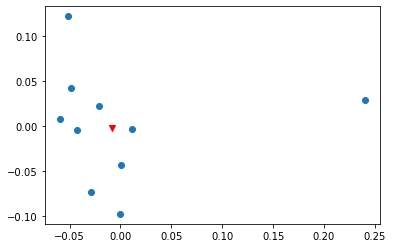

In [44]:
# %%writefile clus_vis.py
import os
import pickle
import numpy as np
import scipy

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance

saver_path = os.path.join('saver', 'femnist')
pk_path = os.path.join(saver_path, 'clients_dense_r100.pb')

with open(pk_path, 'rb') as f:
    data = pickle.load(f)
    
array = np.array([ i[1] for i in data])
tmp_arr = array.reshape((len(data), -1))
# m = np.median(tmp_arr, axis=0)
m = scipy.stats.trim_mean(tmp_arr, 0.1, axis=0)

pca_2 = PCA(n_components =2)
tsne = TSNE(n_components=2, perplexity=200)

conv_x = pca_2.fit_transform(tmp_arr)
print(conv_x)
# conv_x[3][1] = -0.0020545
# conv_x[9][1] = 0.04606113

import matplotlib.pyplot as plt

x = [pos[0] for pos in conv_x]
y = [pos[1] for pos in conv_x]
center = pca_2.transform(m.reshape((1, tmp_arr.shape[1])))
print(center)
for i, point in enumerate(conv_x):
    print("{:02d}-distant to center={}".format(i, distance.sqeuclidean(point, center) * 10))
plt.scatter(x, y)
plt.scatter(center[0][0], center[0][1], marker='v', color='r')
# plt.scatter(center[0], center[1], marker='v', color='r')
plt.show

In [46]:
##### clients = [ i[0] for i in data]
print(clients)

['f2156_56', 'f3932_35', 'f1799_27', 'f3380_04', 'f3216_33', 'f1741_16', 'f3258_46', 'f1568_21', 'f0095_41', 'f3442_00']


In [40]:
import csv

wrtr = csv.writer(open("./dense_reduction.csv","w"))
for x in conv_x:
    wrtr.writerow( [ str(x[0]), str(x[1]) ])